# 2.5 웹 검색을 지원하는 Corrective RAG

- [Corrective Retrieval Augmented Generation](https://arxiv.org/pdf/2401.15884)논문을 구현합니다
- LangGraph 공식문서에 나온 흐름을 따라갑니다
    - 공식문서의 흐름은 간소화된 버전입니다.
    - 실제 논문과 유사한 구현은 3.3강을 참고해주세요
![corrective-rag](https://i.imgur.com/IzvmbWN.png)

- 여기서 rewrite 노드는 앞에 것과 약간 차이가 있는데, web search를 잘하도록 하도록 쿼리를 수정한다.

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

### 기존과 동일한 코드

In [2]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model='text-embedding-3-large')

vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name = 'income_tax_collection',
    persist_directory = './income_tax_collection'
)
retriever = vector_store.as_retriever(search_kwargs={'k': 3})

In [3]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: list # 웹 검색 결과가 들어 갈수 있어서 list[Document]로 명시하지 않았다.
    answer: str
    
graph_builder = StateGraph(AgentState)

In [4]:
def retrieve(state: AgentState) -> AgentState:
    """
    사용자의 질문에 기반하여 벡터 스토어에서 관련 문서를 검색합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 검색된 문서가 추가된 state를 반환합니다.
    """
    query = state['query']
    docs = retriever.invoke(query)
    return {'context': docs}

In [5]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

In [6]:
from langchain import hub

# 허브에서 RAG 프롬프트를 가져옵니다
generate_prompt = hub.pull("rlm/rag-prompt")

# 지정된 매개변수로 언어 모델을 초기화합니다
generate_llm = ChatOpenAI(model='gpt-4o', max_completion_tokens=100)

def generate(state: AgentState) -> AgentState:
    """
    주어진 state를 기반으로 RAG 체인을 사용하여 응답을 생성합니다.

    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 생성된 응답을 포함하는 state를 반환합니다.
    """
    context = state['context']
    query = state['query']
    
    rag_chain = generate_prompt | generate_llm
    
    response = rag_chain.invoke({'question': query, 'context': context})
    
    return {'answer': response.content} # 앞과 다르게 content를 반환하여 string 출력

`retrieve` 노드에서 추출된 문서와 사용자의 질문이 관련이 있는지 판단
- 문서와 관련이 없다면 `rewrite` 노드로 이동해서 사용자의 질문을 변경
    - `rewrite` 후 다시 `web_search` 노드로 이동해서 웹 검색
- 문서와 관련이 있다면 `generate` 노드로 이동해서 답변을 생성

In [7]:
# set the LANGCHAIN_API_KEY environment variable (create key in settings)
from langchain import hub
from typing import Literal
doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevance(state: AgentState) -> Literal['relevant', 'irrelvant']:
    """
    주어진 state를 기반으로 문서의 관련성을 판단합니다.

    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state.

    Returns:
        Literal['relevant', 'irrelevant']: 문서가 관련성이 높으면 'relevant', 그렇지 않으면 'irrelevant'를 반환합니다.
    """
    query = state['query']
    context = state['context']

    doc_relevance_chain = doc_relevance_prompt | llm
    response = doc_relevance_chain.invoke({'question': query, 'documents': context})

    if response['Score'] == 1:
        return 'relevant'
    
    return 'irrelvant'

### 추가 노드 구현

rewrite는 웹검색에 용이하게...

In [8]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

rewrite_prompt = PromptTemplate.from_template("""사용자의 질문을 보고, 웹 검색에 용이하게 사용자의 질문을 수정해주세요
질문: {query}
""")

def rewrite(state: AgentState):
    """
    사용자의 질문을 사전을 참고하여 변경합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 변경된 질문을 포함하는 state를 반환합니다.
    """
    query = state['query']
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()

    response = rewrite_chain.invoke({'query': query})

    return {'query': response}


`web_search` 노드에서 웹 검색 진행
- `retrieve` 결과 대신 웹 검색 결과를 사용
- 웹 검색 결과는 [TavilySearchResults](https://tavily.com/) 툴을 사용

In [9]:
from langchain_community.tools import TavilySearchResults

tavily_search_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

def web_search(state: AgentState) -> AgentState:
    """
    주어진 state를 기반으로 웹 검색을 수행합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 웹 검색 결과가 추가된 state를 반환합니다.
    """
    query = state['query']
    results = tavily_search_tool.invoke(query)

    return {'context': results}

`node`를 추가하고 `edge`로 연결

In [10]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
# graph_builder.add_node('rewrite', rewrite) # rewrite를 여기서는 재외해보았음. 결국 web search를 위한 rewrite는 필요 없을 수도
graph_builder.add_node('web_search', web_search)

In [11]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges(
    'retrieve',
    check_doc_relevance,
    {
        'relevant': 'generate',
        'irrelvant': 'web_search'
    }
)
# graph_builder.add_edge('rewrite', 'web_search')
graph_builder.add_edge('web_search', 'generate')
graph_builder.add_edge('generate', END)

In [12]:
graph = graph_builder.compile()

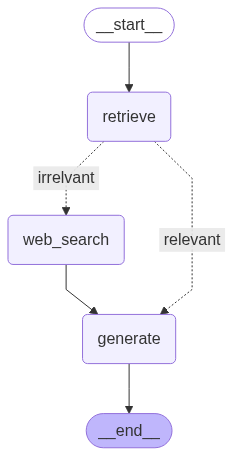

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
initial_state = {'query': '연봉 5천만원 거주자의 소득세는 얼마인가요?'}
graph.invoke(initial_state)

{'query': '연봉 5천만원 거주자의 소득세는 얼마인가요?',
 'context': [Document(metadata={'source': './documents/income_tax.txt'}, page_content='| 종합소득         | 세 율                                  |\n|------------------|---------------------------------------|\n| 1,400만원 이하   | 과세표준의 6세례셋트                      |\n| 1,400만원 초과   | 84만원 + (1,400만원을 초과하는 금액의 15%)  |\n| 5,000만원 이하   | 624만원 + (5,000만원을 초과하는 금액의 24%)  |\n| 8,800만원 이하   | 1,536만원 + (8,800만원을 초과하는 금액의 35%) |\n| 1억5천만원 이하  | 3,706만원 + (1억5천만원을 초과하는 금액의 38%) |\n| 3억 이하         | 9,460만원 + (3억을 초과하는 금액의 40%)      |\n| 5억 이하         | 1억7,406만원 + (5억을 초과하는 금액의 42%)   |\n| 10억 이하        | 3억8,406만원 + (10억을 초과하는 금액의 45%)  |\n법제처 35 \n국가법령정보센터\n소득세법\n② 거주자의 퇴직소득에 대한 소득세는 다음 각 호의 순서에 따라 계산한 금액(이하 "퇴직소득 산출세액"이라 한다)으로 한다.\n<개정> 2013. 1. 1, 2014. 12. 23.\n1. 해당 사업기간의 퇴직소득세표준(제1항의 세율을 적용하여 계산한 금액\n2. 제1호의 금액을 12로 나눈 금액에 근속연수를 곱한 금액\n3. 삭제<2014. 12. 23.>\n[전문개정 2009. 12. 31.]\n제2장 세액공제\n<개정> 2009. 12. 31.\n제56조(배당세액공제)\n① 거주자의 종합소득금액에 제17조제3항 각 호의 부분 단서가 적

In [15]:
initial_state = {'query': '역삼역 맛집을 추천해주세요'}
graph.invoke(initial_state)

{'query': '역삼역 맛집을 추천해주세요',
 'context': [{'url': 'https://www.diningcode.com/list.dc?query=%EC%97%AD%EC%82%BC%EC%97%AD%20%ED%98%84%EC%A7%80%EC%9D%B8%EC%B6%94%EC%B2%9C',
   'content': '역삼역 현지인추천맛집 (60곳) · 1. 논현손칼국수 언주역 · 2. 십원집 강남역점 · 3. 온수반 역삼점 · 4. 서울깍두기 강남역삼점 · 5. 이여곰탕 역삼점 · 6. 온심옥 역삼'},
  {'url': 'https://baby.tali.kr/201',
   'content': '솥밥인데 그냥 솥밥이 아니라 고급스러운 재료들로 푸짐하게 올려진 솥밥입니다. 스테이크, 도미관자, 장어, 전복 솥밥과 같은 메뉴가 준비되어 있습니다. 건강하고 든든하게 드시고 싶을때 추천하는 역삼역 직장인 입소문 맛집입니다.\n\n대표 메뉴 : 스테이크솥밥 17,000원\n\n주소 : 서울특별시 강남구 논현로94길 23 지상1층 101, 102호\n\n전화번호 : 010-6724-8858\n\n## [3위] 츄라우미 역삼본점\n\n창가쪽 자리에 앉으시면 분위기가 더욱 좋습니다. 매콤 해산물 나베와 같은 맛있는 안주들이 있는 이자카야입니다. 강남에서 퇴근하고 가볍게 한 잔 걸치는 직장인, 멋지지 않나요? 다이닝 이자카야 츄라우미 역삼본점이 3위입니다.\n\n대표 메뉴 : 세이로무시 65,000원\n\n주소 : 서울특별시 강남구 언주로93길 21 남전타운\n\n전화번호 : 0507-1425-7771\n\n## [4위] 신동궁감자탕 역삼직영점 [...] 오늘처럼 주륵주륵 비내리는 날이면 생각나는 곳입니다. 따뜻한 국물과 얼큰한 김치칼국수 정말 너무 맛있네요. 역삼역 근처 직장인들 사이에서 낮술의 성지로 소문난 맛집이기도 합니다.\n\n대표 메뉴 : 선덕 닭곰탕 12,000원\n\n주소 : 서울특별시 강남구 테헤란로27길 29 주암빌딩 B1\n\n전화번호 : 05